## [Computational Social Science] Project 5: Natural Language Processing

In this project, you will use natural language processing techniques to explore a dataset containing tweets from members of the 116th United States Congress that met from January 3, 2019 to January 2, 2021. The dataset has also been cleaned to contain information about each legislator. Concretely, you will do the following:

* Preprocess the text of legislators' tweets
* Conduct Exploratory Data Analysis of the text
* Use sentiment analysis to explore differences between legislators' tweets
* Featurize text with manual feature engineering, frequency-based, and vector-based techniques
* Predict legislators' political parties and whether they are a Senator or Representative

You will explore two questions that relate to two central findings in political science and examine how they relate to the text of legislators' tweets. First, political scientists have argued that U.S. politics is currently highly polarized relative to other periods in American history, but also that the polarization is asymmetric. Historically, there were several conservative Democrats (i.e. "blue dog Democrats") and liberal Republicans (i.e. "Rockefeller Republicans"), as measured by popular measurement tools like [DW-NOMINATE](https://en.wikipedia.org/wiki/NOMINATE_(scaling_method)#:~:text=DW\%2DNOMINATE\%20scores\%20have\%20been,in\%20the\%20liberal\%2Dconservative\%20scale.). However, in the last few years, there are few if any examples of any Democrat in Congress being further to the right than any Republican and vice versa. At the same time, scholars have argued that this polarization is mostly a function of the Republican party moving further right than the Democratic party has moved left. **Does this sort of asymmetric polarization show up in how politicians communicate to their constituents through tweets?**

Second, the U.S. Congress is a bicameral legislature, and there has long been debate about partisanship in the Senate versus the House. The House of Representatives is apportioned by population and all members serve two year terms. In the Senate, each state receives two Senators and each Senator serves a term of six years. For a variety of reasons (smaller chamber size, more insulation from the voters, rules and norms like the filibuster, etc.), the Senate has been argued to be the "cooling saucer" of Congress in that it is more bipartisan and moderate than the House. **Does the theory that the Senate is more moderate have support in Senators' tweets?**

**Note**: See the project handout for more details on caveats and the data dictionary.

In [1]:
# pandas and numpy
import pandas as pd
import numpy as np

# punctuation, stop words and English language model
from string import punctuation
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
nlp = en_core_web_sm.load()

# textblob
from textblob import TextBlob

# countvectorizer, tfidfvectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

# gensim
import gensim
from gensim import models

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Classification
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
!pip install emoji
import emoji

  Using cached emoji-2.14.1-py3-none-any.whl.metadata (5.7 kB)
Using cached emoji-2.14.1-py3-none-any.whl (590 kB)


In [3]:
!pip install contractions
import contractions

  Using cached contractions-0.1.73-py2.py3-none-any.whl.metadata (1.2 kB)
  Using cached textsearch-0.0.24-py2.py3-none-any.whl.metadata (1.2 kB)
  Using cached anyascii-0.3.2-py3-none-any.whl.metadata (1.5 kB)
  Using cached pyahocorasick-2.1.0-cp312-cp312-macosx_10_9_universal2.whl.metadata (13 kB)
Using cached contractions-0.1.73-py2.py3-none-any.whl (8.7 kB)
Using cached textsearch-0.0.24-py2.py3-none-any.whl (7.6 kB)
Using cached anyascii-0.3.2-py3-none-any.whl (289 kB)
Using cached pyahocorasick-2.1.0-cp312-cp312-macosx_10_9_universal2.whl (63 kB)


In [4]:
import html
import re

In [74]:
# load data
# ----------
congress_tweets = pd.read_csv("data/116th Congressional Tweets and Demographics.csv"，
                             low_memory=False)
# fill in this line of code with a sufficient number of tweets, depending on your computational resources
congress_tweets = congress_tweets.sample(5000,
                                        random_state = 42)

SyntaxError: invalid character '，' (U+FF0C) (1855369790.py, line 3)

In [6]:
pd.options.display.max_colwidth = None
print(congress_tweets['text'][:10])

445325                                                                                                                                                                                                                                                                                                                 I introduced the Main Street Growth Act to get more companies to go public and allow everyone to share in America’s booming markets. You can read more about my bill here https://emmer.house.gov/press-releases?ContentRecord_id=53235569-51F9-4892-93D1-C6E2D56932B9  #NatlEshipWeek
48352                                                                                                                                                                                                                                                                                             Pleased I was able to meet with @uapbchancellor Dr. Laurence Alexander today about what’s happening on the campus of UAP

Tweet data includes **(1) URLs, mentions, retweets (RTs), quote tweets(QT), and hashtags; (2) Formatting markers such as “&amp” and “\n \n”; (3) Emojis and informal expressions (e.g., “w/”).**  
Beside applying the standard text preprocessing, I will first clean the tweet data. Specifically, I will remove all URLs, mentions, RTs, and formatting markers. However, since hashtags may contain valuable information, I will strip the “#” symbol while retaining the words within the hashtags. I will expand contractions and convert emojis into their corresponding text descriptions to enhance text clarity.

## Preprocessing

The first step in working with text data is to preprocess it. Make sure you do the following:

* Remove punctuation and stop words. The `rem_punc_stop()` function we used in lab is provided to you but you should feel free to edit it as necessary for other steps
* Remove tokens that occur frequently in tweets, but may not be helpful for downstream classification. For instance, many tweets contain a flag for retweeting, or share a URL

As you search online, you might run into solutions that rely on regular expressions. You are free to use these, but you should also be able to preprocess using the techniques we covered in lab. Specifically, we encourage you to use spaCy's token attributes and string methods to do some of this text preprocessing.

In [7]:
congress_tweets = congress_tweets.reset_index(drop=True)

In [8]:
# Special Cases on Party Membership
# two independent Senators - treat as Democratic Party
congress_tweets.loc[congress_tweets['name_wikipedia'] == 'Bernie Sanders', 'party'] = 'Democrat'
congress_tweets.loc[congress_tweets['name_wikipedia'] == 'Angus King', 'party'] = 'Democrat'

# three party switches - drop
congress_tweets = congress_tweets.drop(congress_tweets[congress_tweets['name_wikipedia'] == 'Justin Amash'].index)
congress_tweets = congress_tweets.drop(congress_tweets[congress_tweets['name_wikipedia'] == 'Paul Mitchell'].index)
congress_tweets = congress_tweets.drop(congress_tweets[congress_tweets['name_wikipedia'] == 'Jeff Van Drew'].index)

For special cases regarding party membership:

**Two independent senators:** Since senators are already a minority group, we want to avoid losing samples. Given that these two senators caucus with the Democratic Party, it is reasonable to assume that their political stance is similar to that of the Democrats. Therefore, I classify their party as the Democratic Party.

**Three party switchers:** Party switching is an unusual occurrence. Short-term party changes may be driven by political opportunism, so I remove these data points. However, if there were a large number of records related to party switching, they could actually serve as evidence for identifying party affiliation and tweet patterns.

In [9]:
# convert emojis
congress_tweets['text'] = congress_tweets['text'].apply(lambda x: emoji.demojize(x, delimiters=(' ', ' ')))

In [10]:
# expand contractions and "w/"
def normalize_text(text):
    text = re.sub(r"[‘’`]", "'", text)
    text = re.sub(r"[“”]", '"', text)
    text = re.sub(r"\bw/\b", "with", text)
    return text

congress_tweets['text'] = congress_tweets['text'].apply(lambda x: contractions.fix(normalize_text(x)))

In [11]:
print(congress_tweets['text'][:10])

0                                                                                                                                                                                                                                                                                                                   I introduced the Main Street Growth Act to get more companies to go public and allow everyone to share in America's booming markets. You can read more about my bill here https://emmer.house.gov/press-releases?ContentRecord_id=53235569-51F9-4892-93D1-C6E2D56932B9  #NatlEshipWeek
1                                                                                                                                                                                                                                                                                             Pleased I was able to meet with @uapbchancellor Dr. Laurence Alexander today about what is happening on the campus of UAPB and 

In [12]:
def rem_punc_stop(text):

    #handle html entities
    text = html.unescape(text)

    #remove "\n\n"
    text = text.replace("\n", " ").replace("\r", " ")

    stop_words = STOP_WORDS

    #remove retweet
    nlp.Defaults.stop_words.update({'rt','qt'})

    #remove punctuation
    punc = set(punctuation)
    punc.discard('@')
    punc_free = "".join([ch for ch in text if ch not in punc])

    #lowercasing & tokenization
    doc = nlp(punc_free.lower())

    spacy_words = []
    skip_next = False
    for token in doc:
        word = token.text
        #remove URLs, mentions, and "#" for hashtags
        if word.startswith('http'):
            continue
        if word.startswith('@'):
            skip_next = True
            continue
        if skip_next and token.is_alpha:
            skip_next = False
            continue
        if word == ' ':
            continue
        spacy_words.append(word)

    no_punc = [word for word in spacy_words if word not in stop_words]
    cleaned_tokens = [word for word in spacy_words if len(word) > 1 and word.isalpha() and word.lower() not in stop_words]

    return cleaned_tokens

In [13]:
congress_tweets['tokens'] = congress_tweets['text'].map(lambda x:rem_punc_stop(x))
congress_tweets['tokens']

0                                                                                                                                                              [introduced, main, street, growth, act, companies, public, allow, share, americas, booming, markets, read, bill, natleshipweek]
1                                                                                                             [pleased, able, meet, laurence, alexander, today, happening, campus, uapb, better, strengthen, assist, hbcus, minorityserving, institutions, including, supporting, future, act]
2       [del, en, california, smallbluediamond, casos, confirmados, hasta, el, día, de, hoy, smallbluediamond, nota, es, posible, que, los, números, representen, los, cambios, verdaderos, de, un, día, otro, ya, que, el, informe, de, los, resultados, de, las, pruebas, puede, retrasarse]
3                                                                                                                                          

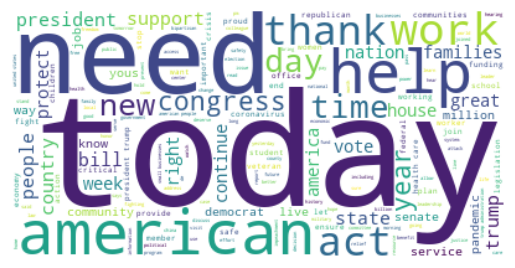

In [14]:
# use wordcloud to check preprocessing quality
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
text = ' '.join(congress_tweets['tokens'].map(lambda text: ' '.join(text)))

wordcloud = WordCloud(background_color = 'white',             # set background color to white
                      random_state=42  # set random state to ensure same word cloud each time
                      ).generate(text)           # change the background color


# plot
plt.imshow(wordcloud,                  # specify wordcloud
           interpolation = 'bilinear') # specifies how the words are displayed
plt.axis('off')                        # turn off axes
plt.show()

## Exploratory Data Analysis

Use two of the techniques we covered in lab (or other techniques outside of lab!) to explore the text of the tweets. You should construct these visualizations with an eye toward the eventual classification tasks: (1) predicting the legislator's political party based on the text of their tweet, and (2) predicting whether the legislator is a Senator or Representative. As a reminder, in lab we covered word frequencies, word clouds, word/character counts, scattertext, and topic modeling as possible exploration tools.

### EDA 1: Lengths and Counts

In [15]:
congress_tweets['length'] = congress_tweets['text'].apply(len)
congress_tweets['word_count'] = congress_tweets['text'].apply(lambda x: len(str(x).split()))

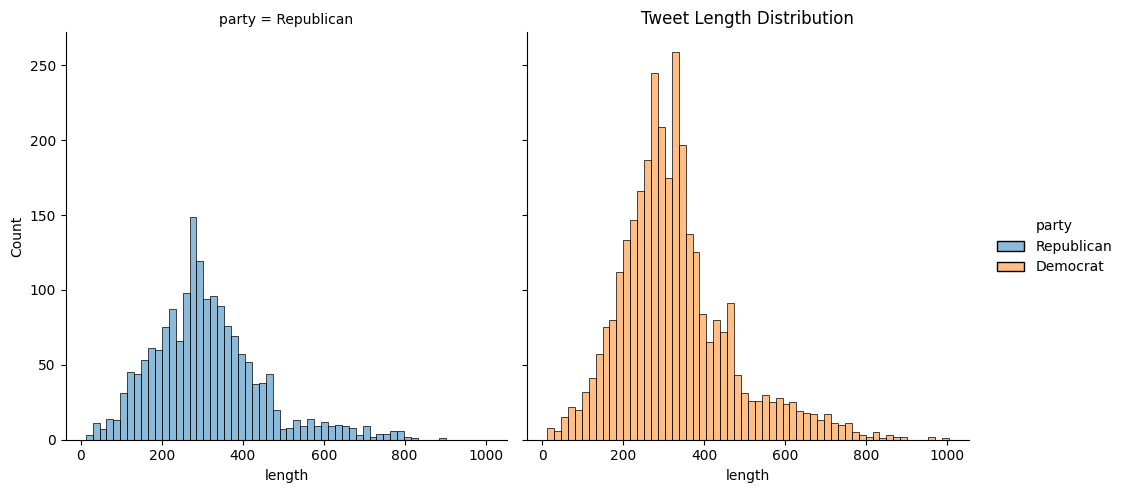

In [16]:
sns.displot(data = congress_tweets,
            x = 'length',
            hue = 'party',
            col = 'party')
plt.title('Tweet Length Distribution')
plt.show()

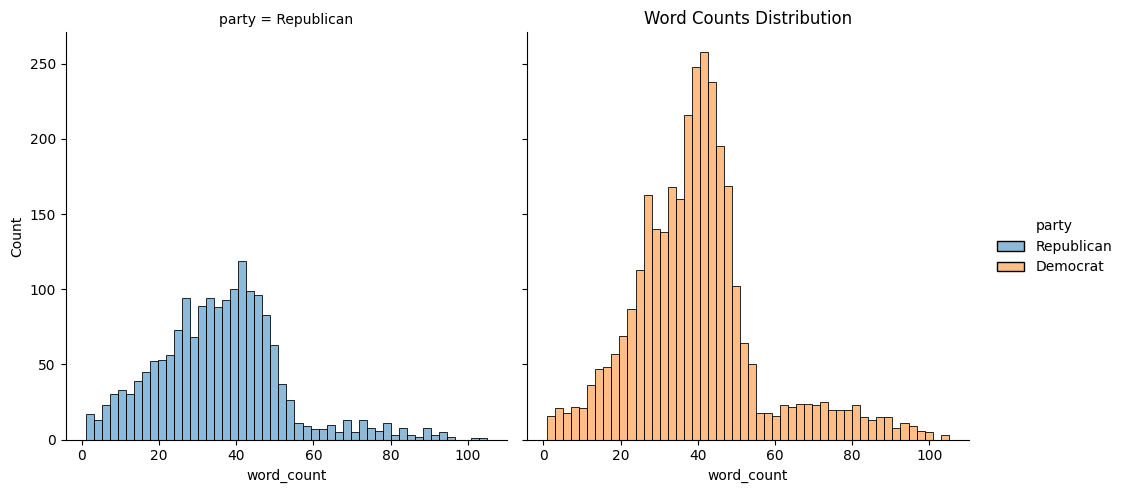

In [17]:
sns.displot(data = congress_tweets,
            x = 'word_count',
            hue = 'party',
            col = 'party')
plt.title('Word Counts Distribution')
plt.show()

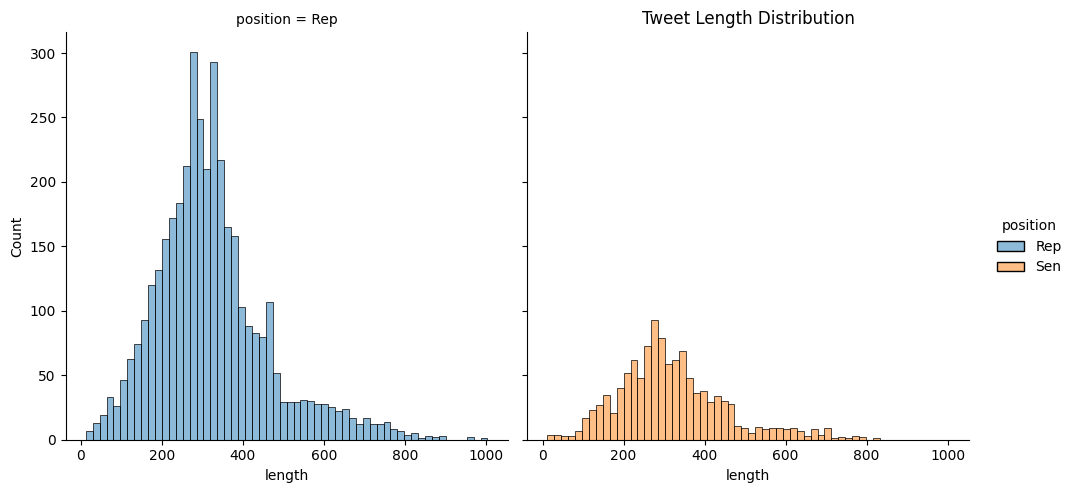

In [18]:
sns.displot(data = congress_tweets,
            x = 'length',
            hue = 'position',
            col = 'position')
plt.title('Tweet Length Distribution')
plt.show()

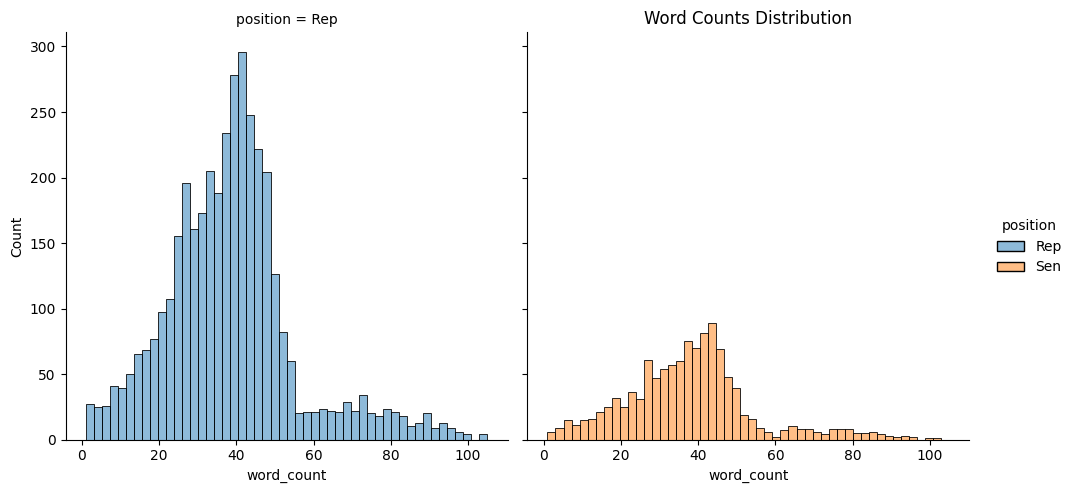

In [19]:
sns.displot(data = congress_tweets,
            x = 'word_count',
            hue = 'position',
            col = 'position')
plt.title('Word Counts Distribution')
plt.show()

In [20]:
summary_length = congress_tweets.groupby('party')['length'].describe()
summary_length = pd.concat([summary_length, congress_tweets.groupby('position')['length'].describe()])
summary_length

,count,mean,std,min,25%,50%,75%,max
Democrat,3240.0,328.232407,138.961955,12.0,240.75,309.0,386.0,1004.0
Republican,1754.0,311.195553,136.851433,22.0,222.00,294.0,378.0,895.0
Rep,3851.0,323.294469,139.821515,12.0,236.00,305.0,381.5,1004.0
Sen,1143.0,318.725284,133.724046,19.0,230.00,297.0,386.0,826.0


In [21]:
summary_word_count = congress_tweets.groupby('party')['word_count'].describe()
summary_word_count = pd.concat([summary_word_count, congress_tweets.groupby('position')['word_count'].describe()])
summary_word_count

,count,mean,std,min,25%,50%,75%,max
Democrat,3240.0,39.794444,16.794649,1.0,30.0,39.0,46.0,105.0
Republican,1754.0,35.902509,16.555846,1.0,25.0,36.0,45.0,105.0
Rep,3851.0,38.597767,16.838653,1.0,28.0,38.0,46.0,105.0
Sen,1143.0,37.853893,16.718610,1.0,28.0,38.0,45.0,102.0


Democratic tweets tend to be longer and more detailed, with an average of 39.79 words vs. 35.90 and 328.23 characters vs. 311.19 compared to Republican tweets.Republican tweets are generally shorter and more varied in length, with a higher frequency of very short tweets.

House Representatives (Rep) tend to write longer and more variable tweets, with the longest reaching 1,004 characters. Senators (Sen) have more consistent tweet lengths.

Democrats tend to provide more detailed expressions, while Republicans favor shorter, more impactful communication. This suggests a difference in stylistic approach between the two parties. House representatives show more flexibility in their tweets, whereas senators maintain a relatively uniform style.

### EDA 2: WordCloud and Topic Modeling

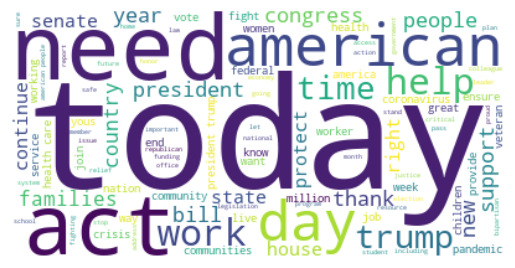

In [22]:
dem_tweets = congress_tweets[congress_tweets['party'] == 'Democrat']
rep_tweets = congress_tweets[congress_tweets['party'] == 'Republican']

dem_text = ' '.join(dem_tweets['tokens'].map(lambda text: ' '.join(text)))
rep_text = ' '.join(rep_tweets['tokens'].map(lambda text: ' '.join(text)))

dem_wordcloud = WordCloud(background_color = 'white',
                      random_state=42
                      ).generate(dem_text)

rep_wordcloud = WordCloud(background_color = 'white',
                      random_state=42
                      ).generate(rep_text)


# plot
plt.imshow(dem_wordcloud,
           interpolation = 'bilinear')
plt.axis('off')
plt.show()

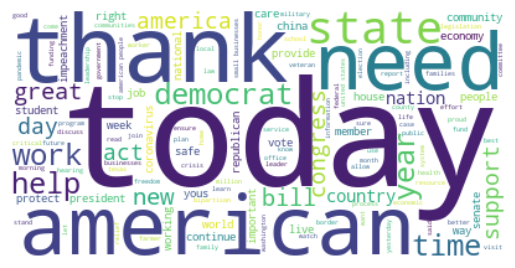

In [23]:
plt.imshow(rep_wordcloud,
           interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [24]:
tf = TfidfVectorizer(tokenizer = rem_punc_stop,
                     token_pattern = None)
tfidf_matrix = tf.fit_transform(congress_tweets['tokens'].str.join(' '))
dense_matrix = tfidf_matrix.todense()

In [25]:
lda = LatentDirichletAllocation(n_components = 5,
                                max_iter = 20,
                                random_state = 42)
lda = lda.fit(np.asarray(dense_matrix))

In [26]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #{}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [27]:
tf_feature_names = tf.get_feature_names_out()

print_top_words(lda,
                tf_feature_names,
                20)

topic_dist = lda.transform(tfidf_matrix)
topic_dist_df = pd.DataFrame(topic_dist).reset_index(drop = True)

topic_dist_df


Topic #0:
nurses statement tune doctors transcript backhandindexpointingdown refugees daca floyd joining fort read purpose collins explanation hong justiceact offered radio kong

Topic #1:
today people act need trump house health president work time help congress american bill americans support care new senate day

Topic #2:
telephone king congratulations happy socialism game jr grand practice birthday wish loss monitoring participating pt luther hall best martin celebrating

Topic #3:
de en la wishing los que el para del happy las advocacy newsletter love vietnam soil se pfas corner merry

Topic #4:
schiff adam knows hunt witch sham summer section fisa dear spot charge compelling overwhelming chibokgirls americafirst miami rice stopped species



,0,1,2,3,4
0,0.042028,0.831978,0.041997,0.041998,0.041999
1,0.274176,0.610386,0.038366,0.038367,0.038705
2,0.033544,0.034121,0.033545,0.865230,0.033560
3,0.043406,0.826358,0.043404,0.043420,0.043412
4,0.044224,0.657536,0.044458,0.044222,0.209560
...,...,...,...,...,...
4989,0.043070,0.827726,0.043077,0.043064,0.043063
4990,0.042472,0.830106,0.042479,0.042472,0.042472
4991,0.041768,0.640532,0.234130,0.041825,0.041746
4992,0.041937,0.832250,0.041937,0.041938,0.041938


In [28]:
party_topic_dist = topic_dist_df.groupby(congress_tweets['party']).mean()
print(party_topic_dist) 

                   0         1         2         3         4
party                                                       
Democrat    0.080761  0.696382  0.078976  0.073112  0.070769
Republican  0.078244  0.693459  0.081761  0.071402  0.075134


In [29]:
party_topic_dist = topic_dist_df.groupby(congress_tweets['position']).mean()
print(party_topic_dist) 

                 0         1         2         3        4
position                                                 
Rep       0.079734  0.697502  0.078876  0.071498  0.07239
Sen       0.080355  0.688126  0.083585  0.075924  0.07201


Wordclouds seem to provide limited actionable insights, whereas topic modeling results are likely to be more interpretable:
**Topic #0:** Covers healthcare, social justice, immigration, and international affairs.
**Topic #1:** Focuses on government actions, legislation, the president, and policymaking.
**Topic #2:** Relates to commemorations, historical figures, and cultural celebrations, such as mentions of "King, Luther" (Ideally they should be treated as one token?).
**Topic #3:** Likely associated with Spanish-language tweets, potentially related to Latino voters and immigration issues.
**Topic #4:** Involves political investigations, FISA, government surveillance, and partisan conflicts.

Republicans are more likely to mention Topic #2 (commemorations) and Topic #4 (political investigations), with a particularly strong emphasis on Topic #4. Democrats are more likely to discuss Topic #3 (Spanish-language content, Latino voters, and immigration issues). 
Senators mention Topic #2 (commemorations) and Topic #3 (Spanish-language content) more frequently. For other topics, there is little difference between senators and house representatives.

## Sentiment Analysis

Next, let's analyze the sentiments contained within the tweets. You may use TextBlob or another library for these tasks. Do the following:

* Choose two legislators, one who you think will be more liberal and one who you think will be more conservative, and analyze their sentiment and/or subjectivity scores per tweet. For instance, you might do two scatterplots that plot each legislator's sentiment against their subjectivity, or two density plots for their sentiments. Do the scores match what you thought?
* Plot two more visualizations like the ones you chose in the first part, but do them to compare (1) Democrats v. Republicans and (2) Senators v. Representatives

`TextBlob` has already been imported in the top cell.

### TextBlob

In [30]:
congress_tweets['polarity'] = congress_tweets['tokens'].str.join(' ').map(lambda t: TextBlob(t).sentiment.polarity)
congress_tweets['subjectivity'] = congress_tweets['tokens'].str.join(' ').map(lambda t: TextBlob(t).sentiment.subjectivity)

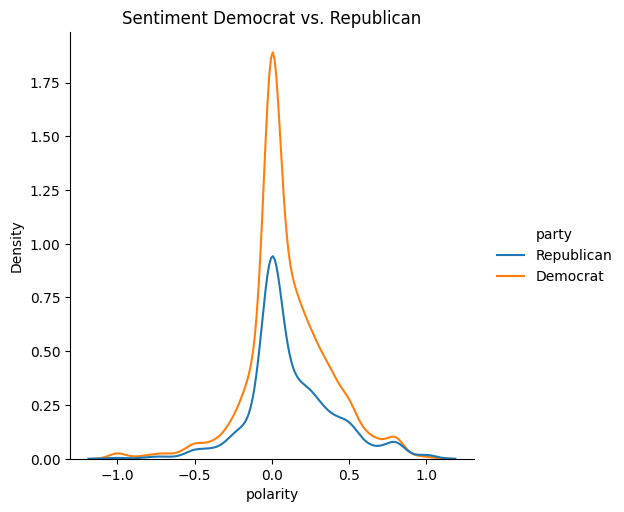

In [31]:
sns.displot(data = congress_tweets,
            x = 'polarity',
            hue = 'party',
            kind = 'kde')
plt.title('Sentiment Democrat vs. Republican')
plt.show()

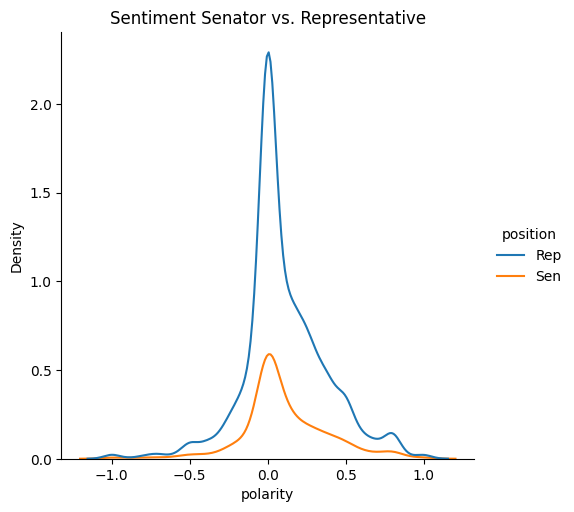

In [32]:
sns.displot(data = congress_tweets,
            x = 'polarity',
            hue = 'position',
            kind = 'kde')
plt.title('Sentiment Senator vs. Representative')
plt.show()

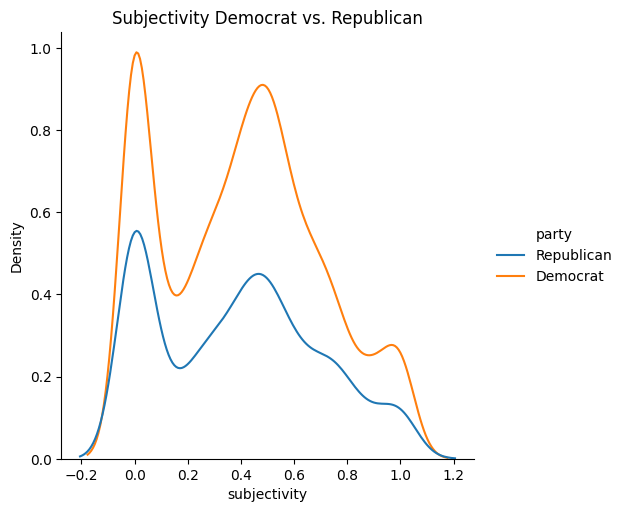

In [33]:
sns.displot(data = congress_tweets,
            x = 'subjectivity',
            hue = 'party',
            kind = 'kde')
plt.title('Subjectivity Democrat vs. Republican')
plt.show()

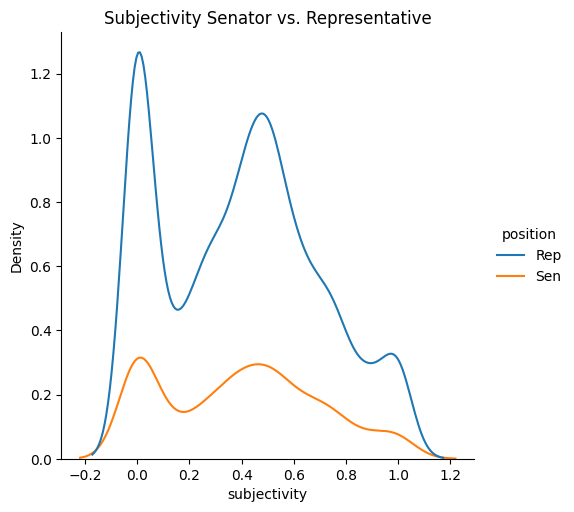

In [34]:
sns.displot(data = congress_tweets,
            x = 'subjectivity',
            hue = 'position',
            kind = 'kde')
plt.title('Subjectivity Senator vs. Representative')
plt.show()

Both Democratic and Republican tweets are generally neutral, with no stark differences in sentiment. However, Democrats lean slightly more positive overall. Senators and House representatives also cluster around neutrality. However, the House representatives’ sentiment distribution is sharper and more concentrated, suggesting they use more consistently neutral language.

Democratic tweets tend to be more subjective, meaning they express personal opinions or attitudes more frequently. Republican tweets appear slightly more objective, though they still contain some degree of subjectivity. Representatives show a higher peak in subjectivity, indicating they use more personal and opinionated language compared to senators, who maintain a more neutral tone.

### VADER

VADER is a library designed for analyzing social media text.

Similar to TextBlob, it primarily relies on dictionary and rule-based methods. However, VADER is specifically fine-tuned for social media, allowing it to better understand negations, capitalization and punctuation. Because of these enhancements, VADER captures sentiment nuances more effectively than TextBlob, making it better suited for analyzing informal, expressive online text.

In [35]:
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

  Using cached vaderSentiment-3.3.2-py2.py3-none-any.whl.metadata (572 bytes)
Using cached vaderSentiment-3.3.2-py2.py3-none-any.whl (125 kB)


In [36]:
vader_analyzer = SentimentIntensityAnalyzer()
congress_tweets['vader_scores'] = congress_tweets['text'].map(lambda t: vader_analyzer.polarity_scores(t))

In [37]:
congress_tweets['vader_scores_compound'] = congress_tweets['vader_scores'].map(lambda t: t['compound'])
congress_tweets['vader_scores_pos'] = congress_tweets['vader_scores'].map(lambda t: t['pos'])
congress_tweets['vader_scores_neu'] = congress_tweets['vader_scores'].map(lambda t: t['neu'])
congress_tweets['vader_scores_neg'] = congress_tweets['vader_scores'].map(lambda t: t['neg'])

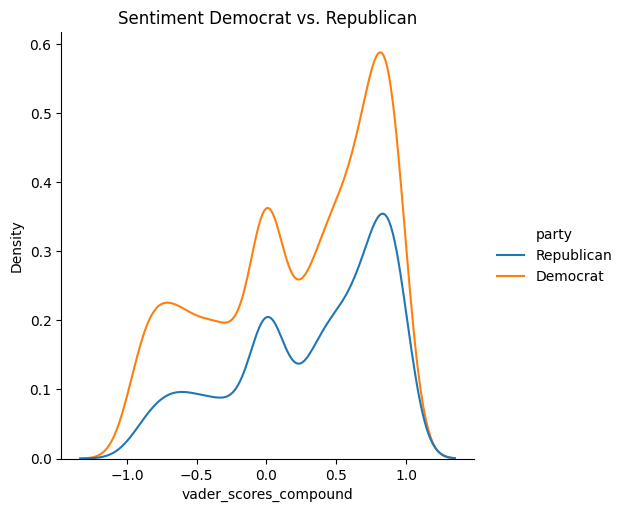

In [38]:
sns.displot(data = congress_tweets,
            x = 'vader_scores_compound',
            hue = 'party',
            kind = 'kde')
plt.title('Sentiment Democrat vs. Republican')
plt.show()

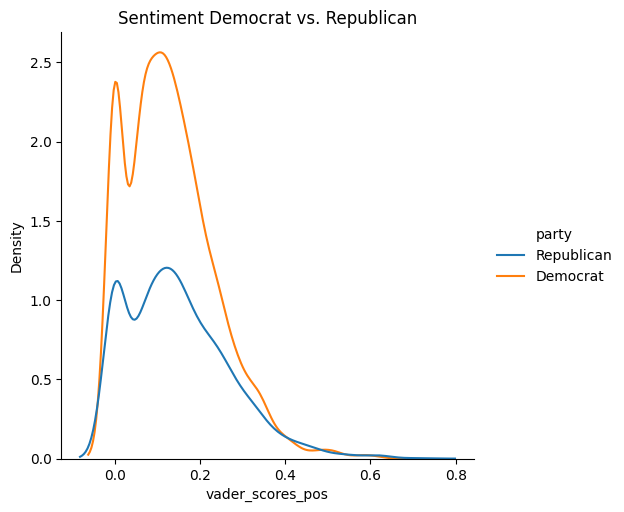

In [39]:
sns.displot(data = congress_tweets,
            x = 'vader_scores_pos',
            hue = 'party',
            kind = 'kde')
plt.title('Sentiment Democrat vs. Republican')
plt.show()

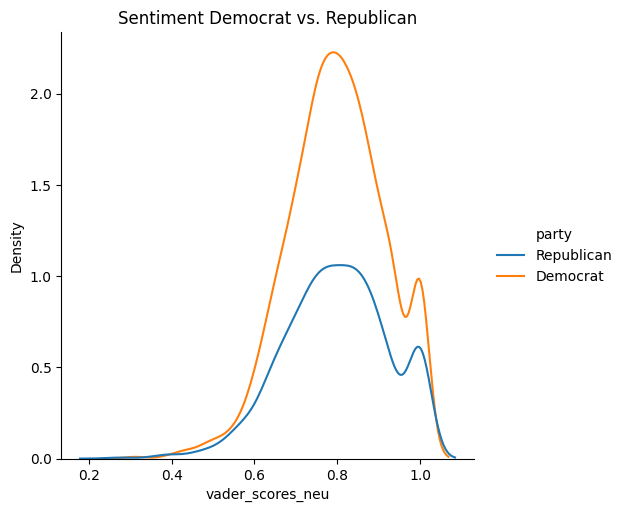

In [40]:
sns.displot(data = congress_tweets,
            x = 'vader_scores_neu',
            hue = 'party',
            kind = 'kde')
plt.title('Sentiment Democrat vs. Republican')
plt.show()

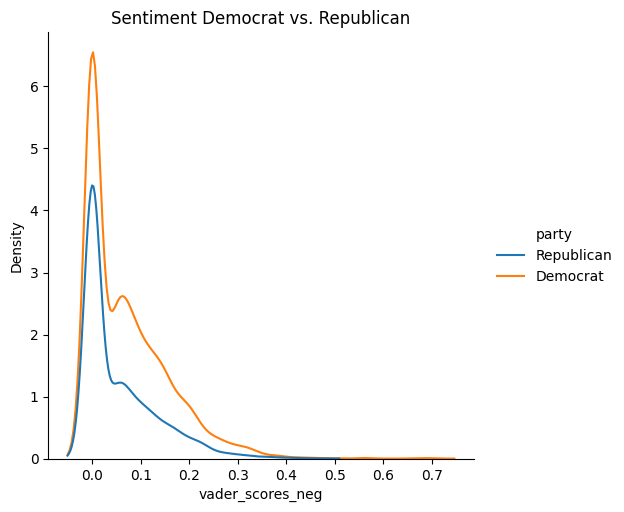

In [41]:
sns.displot(data = congress_tweets,
            x = 'vader_scores_neg',
            hue = 'party',
            kind = 'kde')
plt.title('Sentiment Democrat vs. Republican')
plt.show()

VADER analysis shows that Democrats are detected as using more positive and neutral language overall, while Republican tweets exhibit a slightly higher proportion of negative sentiment. However, both parties still have a significant portion of neutral sentiment in their tweets. The dominance of neutral sentiment is likely due to VADER’s rule-based nature, which lacks the flexibility to interpret context deeply. As a result, most words are classified as neutral, limiting its ability to fully capture nuanced sentiment in political discourse.

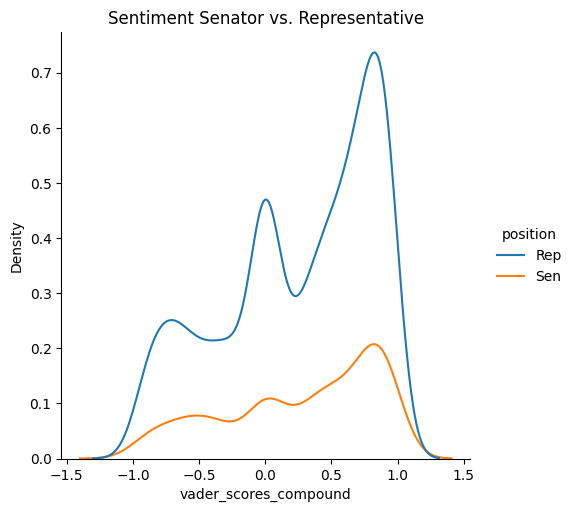

In [42]:
sns.displot(data = congress_tweets,
            x = 'vader_scores_compound',
            hue = 'position',
            kind = 'kde')
plt.title('Sentiment Senator vs. Representative')
plt.show()

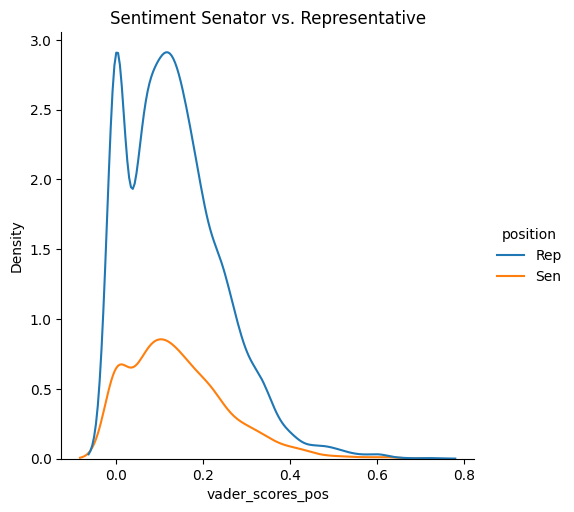

In [43]:
sns.displot(data = congress_tweets,
            x = 'vader_scores_pos',
            hue = 'position',
            kind = 'kde')
plt.title('Sentiment Senator vs. Representative')
plt.show()

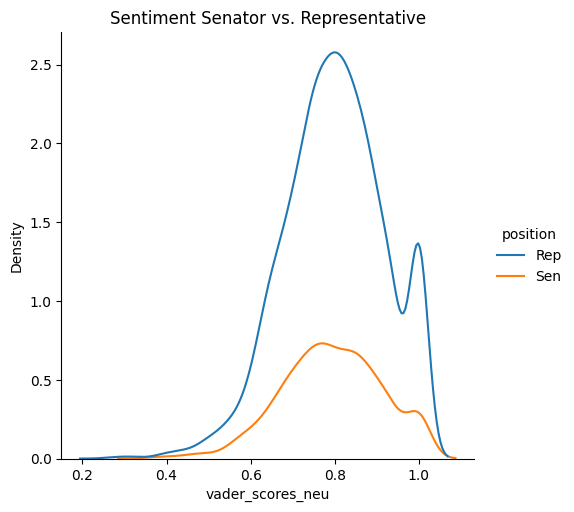

In [44]:
sns.displot(data = congress_tweets,
            x = 'vader_scores_neu',
            hue = 'position',
            kind = 'kde')
plt.title('Sentiment Senator vs. Representative')
plt.show()

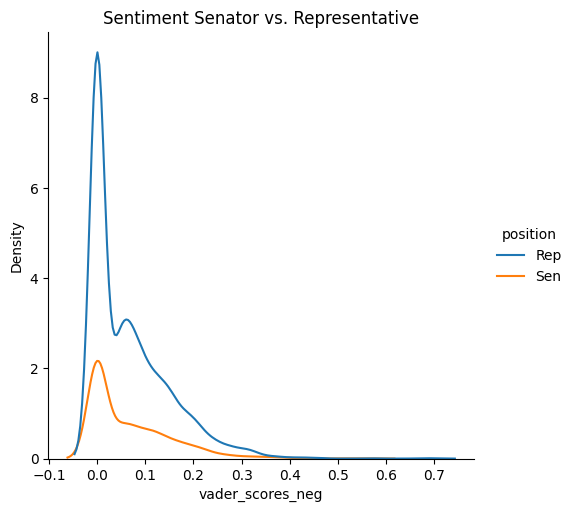

In [45]:
sns.displot(data = congress_tweets,
            x = 'vader_scores_neg',
            hue = 'position',
            kind = 'kde')
plt.title('Sentiment Senator vs. Representative')
plt.show()

Based on the overall compound sentiment score, both House representatives and senators exhibit three peaks, corresponding to negative, neutral, and positive sentiment. The sentiment distribution for senators is smoother, with peaks positioned closer to zero, while House representatives show a more polarized sentiment distribution.
House representatives display stronger peaks in both positive (pos) and negative (neg) sentiment, indicating a greater emotional intensity in their tweets. Senators, on the other hand, maintain a more balanced sentiment distribution, suggesting a less extreme emotional tone in their communication.

## Featurization

Before going to classification, explore different featurization techniques. Create three dataframes or arrays to represent your text features, specifically:

* Features engineered from your previous analysis. For example, word counts, sentiment scores, topic model etc.
* A term frequency-inverse document frequency matrix.
* An embedding-based featurization (like a document averaged word2vec)

In the next section, you will experiment with each of these featurization techniques to see which one produces the best classifications.

### Engineered Text Features

In [46]:
# Engineered Features
engineered_features = congress_tweets[['word_count',
                                       'length',
                                       'polarity',
                                       'subjectivity',
                                       'vader_scores_compound',
                                       'vader_scores_pos',
                                       'vader_scores_neu',
                                       'vader_scores_neg']]

In [47]:
engineered_features_with_topics = topic_dist_df.join(engineered_features.reset_index(drop = True))

### Bag-of-words or Tf-idf

TF-IDF evaluates the importance of a term within a specific document in a given corpus. A word’s importance increases the more frequently it appears within the document, while its importance decreases if it appears too frequently across the entire corpus.

In other words, TF-IDF highlights the most representative and unique terms in a document, helping to distinguish key topics by downplaying common words and emphasizing distinctive ones.

In [48]:
# Frequency Based featurization
tfidf_df = pd.DataFrame(tfidf_matrix.todense(),
                        columns = tf.get_feature_names_out())

### Word Embedding

The fundamental idea behind word embedding is based on distributional similarity (Distributional Hypothesis): words appearing in similar contexts tend to have similar meanings.

Word embedding maps words into a continuous vector space using neural networks or other learning methods, where semantically similar words are positioned closer together in the space.

A straightforward approach to representing an entire document is to take the average of all word vectors within the document, providing a generalized semantic representation of the text.

In [49]:
# Load Word2Vec model from Google; OPTIONAL depending on your computational resources (the file is ~1 GB)
# Also note that this file path assumes that the word vectors are underneath 'data'; you may wish to point to the CSS course repo and change the path
# or move the vector file to the project repo

model = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin.gz', binary = True)

In [50]:
# model = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin.gz', binary=True)

# own_corpus = congress_tweets['tokens'].dropna().tolist()
# own_corpus = [tokens for tokens in own_corpus if isinstance(tokens, list) and len(tokens) > 0]  

# word2vec_model = gensim.models.Word2Vec(vector_size=300, window=5, min_count=1, workers=-1)

# word2vec_model.build_vocab(own_corpus)
# print("Word2Vec vocabulary size:", len(word2vec_model.wv)) 

# common_words = list(set(word2vec_model.wv.index_to_key) & set(model.index_to_key))
# vectors_to_add = np.array([model[word] for word in common_words])

# word2vec_model.wv.add_vectors(common_words, vectors_to_add)

# word2vec_model.train(own_corpus, total_examples=len(own_corpus), epochs=5, compute_loss=True)

In [51]:
# Function to average word embeddings for a document; use examples from lab to apply this function. You can use also other techniques such as PCA and doc2vec instead.
def document_vector(word2vec_model, doc):
    doc = [word for word in doc if word in word2vec_model.key_to_index]  
    return np.mean([word2vec_model.get_vector(word) for word in doc], axis=0) if doc else np.zeros(word2vec_model.vector_size)

In [52]:
empty_list_embeddings_means = []

for doc in congress_tweets['tokens']:
    empty_list_embeddings_means.append(document_vector(model, doc))

doc_average_embeddings = np.array(empty_list_embeddings_means)

In [53]:
# embedding based featurization
word2vec_features_df = pd.DataFrame(doc_average_embeddings)

## Classification

Either use cross-validation or partition your data with training/validation/test sets for this section. Do the following:

* Choose a supervised learning algorithm such as logistic regression, random forest etc.
* Train six models. For each of the three dataframes you created in the featurization part, train one model to predict whether the author of the tweet is a Democrat or Republican, and a second model to predict whether the author is a Senator or Representative.
* Report the accuracy and other relevant metrics for each of these six models.
* Choose the featurization technique associated with your best model. Combine those text features with non-text features. Train two more models: (1) A supervised learning algorithm that uses just the non-text features and (2) a supervised learning algorithm that combines text and non-text features. Report accuracy and other relevant metrics.

If time permits, you are encouraged to use hyperparameter tuning or AutoML techniques like TPOT, but are not explicitly required to do so.

### Train Six Models with Just Text

### Predict Party Membership

In [54]:
print(congress_tweets['party'].value_counts(normalize=True))

party
Democrat      0.648779
Republican    0.351221
Name: proportion, dtype: float64


In [55]:
X = congress_tweets['tokens']
y_party = congress_tweets['party']

In [56]:
dataframes = [engineered_features_with_topics,
              tfidf_df, 
              word2vec_features_df]


featurization_technique = ['Engineered Features + Topic Model',
                           'Tf-idf Features',
                           'Word Embedding Features']

In [57]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y_party) 
print(dict(zip(le.classes_, le.transform(le.classes_))))

{'Democrat': 0, 'Republican': 1}


Best hyperparameters: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
              precision    recall  f1-score   support

    Democrat       0.67      0.64      0.65       810
  Republican       0.38      0.41      0.40       439

    accuracy                           0.56      1249
   macro avg       0.53      0.53      0.53      1249
weighted avg       0.57      0.56      0.56      1249



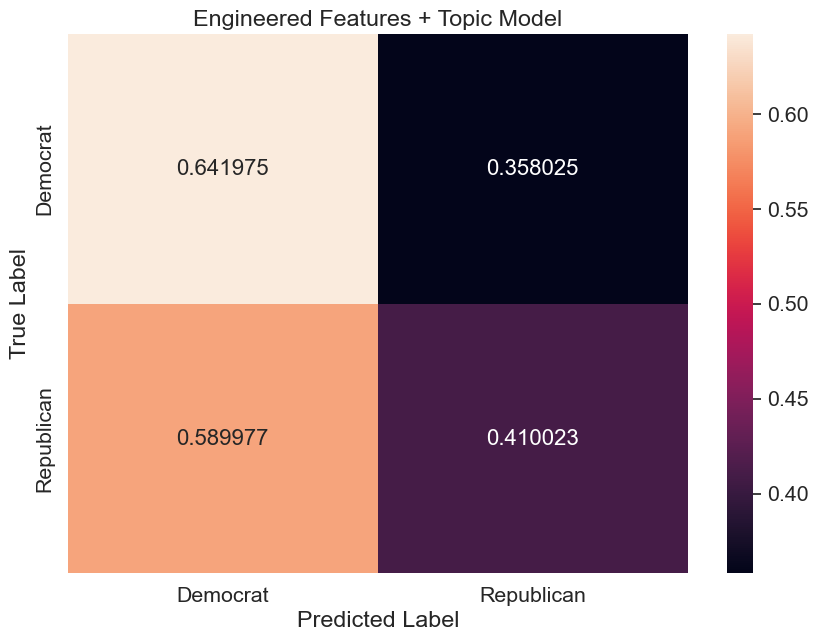

Best hyperparameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
              precision    recall  f1-score   support

    Democrat       0.79      0.76      0.78       810
  Republican       0.59      0.63      0.61       439

    accuracy                           0.71      1249
   macro avg       0.69      0.69      0.69      1249
weighted avg       0.72      0.71      0.72      1249



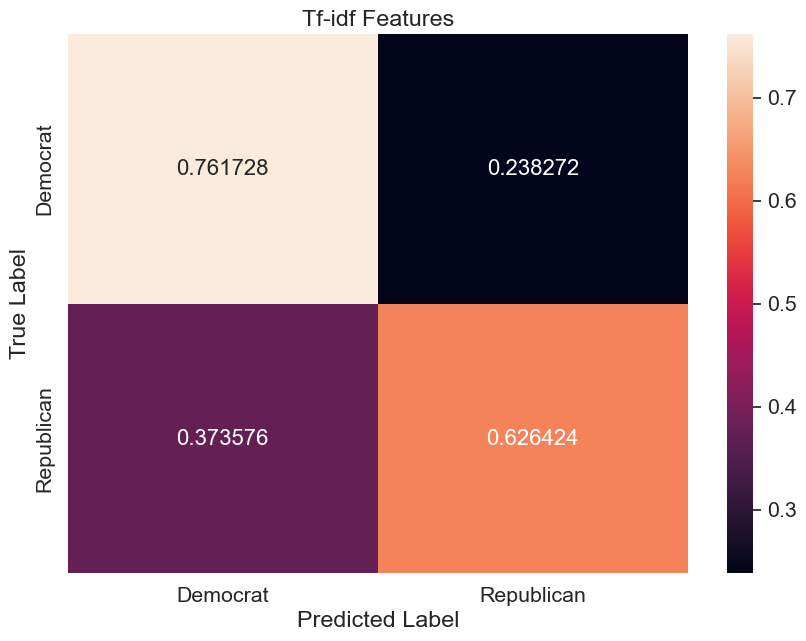

Best hyperparameters: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
              precision    recall  f1-score   support

    Democrat       0.77      0.68      0.72       810
  Republican       0.51      0.62      0.56       439

    accuracy                           0.66      1249
   macro avg       0.64      0.65      0.64      1249
weighted avg       0.68      0.66      0.67      1249



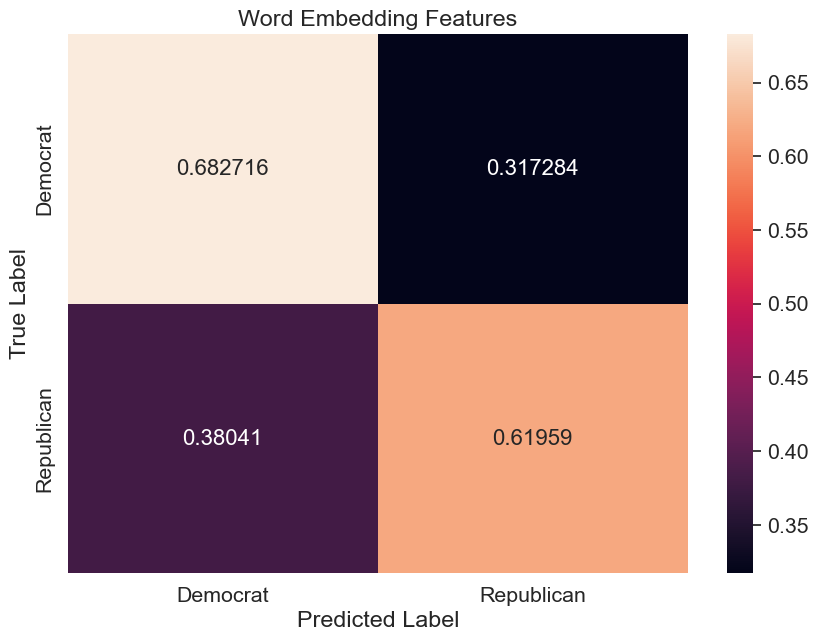

In [58]:
for dataframe, featurization in zip(dataframes, featurization_technique):
    
    dataframe.columns = dataframe.columns.astype(str) 
    
    
    X_train, X_test, y_train, y_test = train_test_split(dataframe,        
                                                        y_party,                 
                                                        train_size = .75, 
                                                        test_size=.25, 
                                                        stratify=  y_party, 
                                                        random_state = 10) 
   
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],  
        'penalty': ['l1', 'l2'],  
        'solver': ['liblinear']  }
    
    logit_reg = LogisticRegression(class_weight='balanced', max_iter=500)
    grid_search = GridSearchCV(logit_reg,
                                param_grid, 
                                cv=5,
                                scoring='accuracy',
                                n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)


    print("Best hyperparameters:", grid_search.best_params_)
    print(classification_report( y_test, y_pred))

    

    cf_matrix = confusion_matrix(y_test,             
                                 y_pred,             
                                 normalize = "true") 

   
    df_cm = pd.DataFrame(cf_matrix,        
                         range(2), range(2)) 

   
    df_cm = df_cm.rename(index=str, 
                         columns={0: "Democrat", 
                                  1: "Republican"})

    
    df_cm.index = ["Democrat", "Republican"]
    
    
    plt.figure(figsize = (10,7)) 
    sns.set(font_scale=1.4)      
    sns.heatmap(df_cm,           
                annot=True,    
                annot_kws={"size": 16},
                fmt='g')
    
    # figure labels
    plt.title(featurization)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

The overall performance of the “Engineered Features + Topic Model” is weak, especially in identifying the Republican category, which has particularly low scores (precision: 0.38, recall: 0.41). This may be because the differences between Democrats and Republicans in these features are not very significant. Additionally, this model has the fewest features, and since Republicans are the minority class, the learning performance is poor.

The TF-IDF model performs the best among the three, significantly improving its ability to identify Republicans (precision: 0.59, recall: 0.63). 

The word embedding model performs better than the “Engineered Features + Topic Model” but is still inferior to TF-IDF. It has a relatively low recall for Democrats (68%) but shows some improvement in identifying Republicans (recall: 0.62).

### Predict Partisanship 

In [59]:
print(congress_tweets['position'].value_counts(normalize=True))

position
Rep    0.771125
Sen    0.228875
Name: proportion, dtype: float64


In [60]:
y_position = congress_tweets['position']
dataframes = [engineered_features_with_topics,
              tfidf_df, 
              word2vec_features_df]


featurization_technique = ['Engineered Features + Topic Model',
                           'Tf-idf Features',
                           'Word Embedding Features']

In [61]:
y_encoded = le.fit_transform(y_position) 
print(dict(zip(le.classes_, le.transform(le.classes_))))

{'Rep': 0, 'Sen': 1}


In [62]:
from imblearn.over_sampling import SMOTE

Best hyperparameters: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
              precision    recall  f1-score   support

         Rep       0.77      0.62      0.69       963
         Sen       0.23      0.38      0.29       286

    accuracy                           0.57      1249
   macro avg       0.50      0.50      0.49      1249
weighted avg       0.65      0.57      0.60      1249



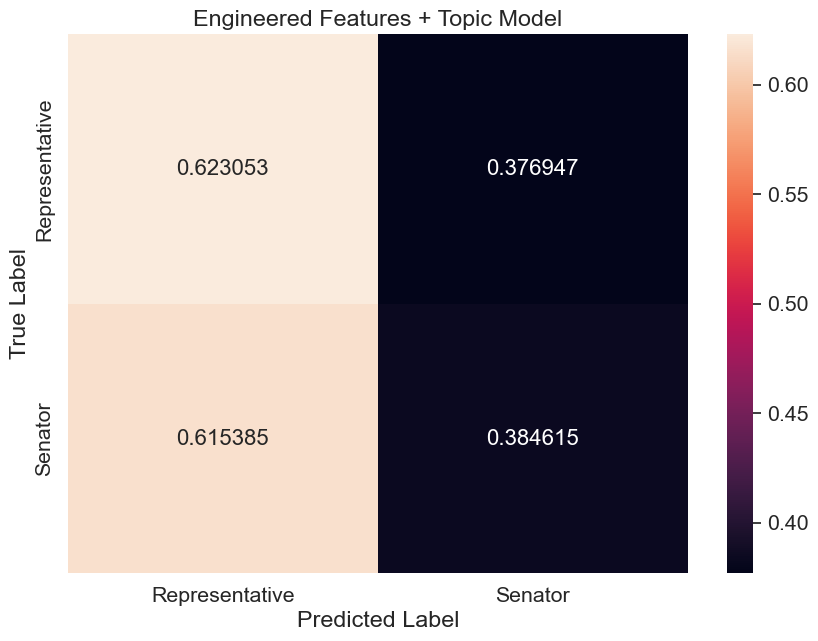

/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best hyperparameters: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
              precision    recall  f1-score   support

         Rep       0.81      0.75      0.78       963
         Sen       0.33      0.42      0.37       286

    accuracy                           0.67      1249
   macro avg       0.57      0.58      0.57      1249
weighted avg       0.70      0.67      0.69      1249



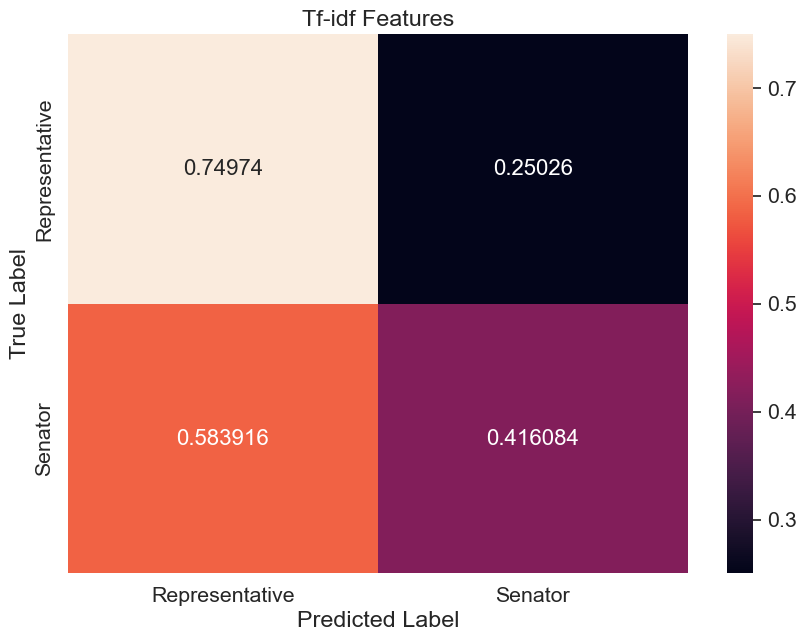

Best hyperparameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
              precision    recall  f1-score   support

         Rep       0.82      0.64      0.72       963
         Sen       0.30      0.52      0.38       286

    accuracy                           0.61      1249
   macro avg       0.56      0.58      0.55      1249
weighted avg       0.70      0.61      0.64      1249



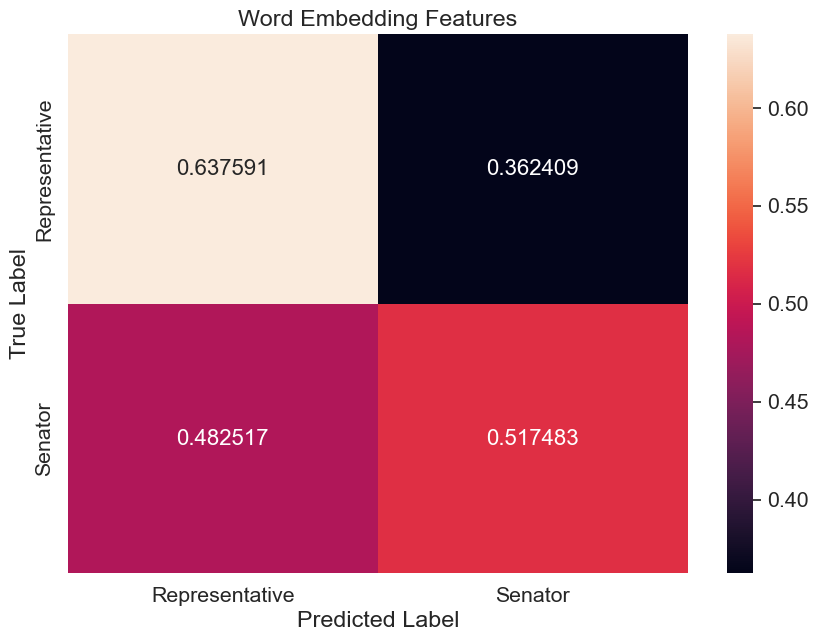

In [63]:
for dataframe, featurization in zip(dataframes, featurization_technique):
    
    dataframe.columns = dataframe.columns.astype(str) 

    X_train, X_test, y_train, y_test = train_test_split(dataframe,         
                                                        y_position,                
                                                        train_size = .75,  
                                                        test_size=.25,
                                                        stratify=y_position, 
                                                        random_state = 10) 
    smote = SMOTE()
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],  
        'penalty': ['l1', 'l2'],  
        'solver': ['liblinear']  }
    
    logit_reg = LogisticRegression(class_weight='balanced',
                                    max_iter=500)
    grid_search = GridSearchCV(logit_reg,
                                param_grid, 
                                cv=5,
                                scoring='accuracy',
                                n_jobs=-1)
    grid_search.fit(X_resampled,y_resampled)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)


    print("Best hyperparameters:", grid_search.best_params_)
    print(classification_report( y_test, y_pred))
    
    
    cf_matrix = confusion_matrix(y_test,             
                                 y_pred,             
                                 normalize = "true") 

    df_cm = pd.DataFrame(cf_matrix,         
                         range(2), range(2)) 

    
    df_cm = df_cm.rename(index=str, 
                         columns={0: "Representative", 
                                  1: "Senator"})

   
    df_cm.index = ["Representative", "Senator"]
    
    
    plt.figure(figsize = (10,7)) 
    sns.set(font_scale=1.4)      
    sns.heatmap(df_cm,           
                annot=True,    
                annot_kws={"size": 16},
                fmt='g')
    

    plt.title(featurization)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

Similar to the models trained for party membership prediction, the “Engineered Features + Topic Model” performs poorly. While it performs reasonably well for House representatives, its recall for Senators is extremely low (only 35.3%).

TF-IDF delivered the best overall performance, achieving the highest accuracy (67%) and the best F1 score for House representatives (0.78), with a slight improvement in senator recall (41%). 

Word embedding performed best in identifying senators, achieving the highest senator recall (54%), but its overall accuracy was lower compared to TF-IDF.

### Two Combined Models

In [64]:
congress_tweets.columns

Index(['tweet_id', 'screen_name', 'datetime', 'text', 'name_wikipedia',
       'position', 'joined_congress_date', 'birthday', 'gender', 'state',
       'district_number', 'party', 'trump_2016_state_share',
       'clinton_2016_state_share', 'obama_2012_state_share',
       'romney_2012_state_share', 'tokens', 'length', 'word_count', 'polarity',
       'subjectivity', 'vader_scores', 'vader_scores_compound',
       'vader_scores_pos', 'vader_scores_neu', 'vader_scores_neg'],
      dtype='object')

### Predict Party Membership with Non-text Features

In [65]:
non_text_features = congress_tweets[['joined_congress_date',
                                     'birthday',
                                     'gender',
                                     'state',
                                     'trump_2016_state_share',
                                     'clinton_2016_state_share',
                                     'obama_2012_state_share',
                                     'romney_2012_state_share']]
non_text_features.head()

,joined_congress_date,birthday,gender,state,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
0,3-Jan-15,3/3/1961,M,MN,"1,322,951","1,367,716","1,546,167","1,320,225"
1,3-Jan-11,12/10/1950,M,AR,"684,872","380,494","394,409","647,744"
2,3-Jan-03,1/28/1969,F,CA,"4,483,814","8,753,792","7,854,285","4,839,958"
3,3-Jan-17,11/23/1950,M,NY,"2,819,533","4,556,118","4,485,741","2,490,431"
4,3-Jan-13,9/16/1974,M,TX,"4,685,047","3,877,868","3,308,124","4,569,843"


In [66]:
non_text_features['joined_congress_date'] = pd.to_datetime(non_text_features['joined_congress_date'], format='%d-%b-%y', errors='coerce')
non_text_features['days_since_joined'] = (pd.Timestamp.today() - non_text_features['joined_congress_date']).dt.days
non_text_features['birthday'] = pd.to_datetime(non_text_features['birthday'], format='%m/%d/%Y', errors='coerce')
non_text_features['age'] = (pd.Timestamp.today() - non_text_features['birthday']).dt.days // 365
non_text_features['gender'] = non_text_features['gender'].map({'M': 0, 'F': 1})
non_text_features = non_text_features.drop(columns=['joined_congress_date', 'birthday'])
for col in ['trump_2016_state_share', 'clinton_2016_state_share', 
            'obama_2012_state_share', 'romney_2012_state_share']:
    non_text_features[col] = non_text_features[col].astype(str).str.replace(',', '').astype(float)

/var/folders/f5/cxwzf1714jl8np8by14r5y8m0000gn/T/ipykernel_1523/2269212510.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_text_features['joined_congress_date'] = pd.to_datetime(non_text_features['joined_congress_date'], format='%d-%b-%y', errors='coerce')
/var/folders/f5/cxwzf1714jl8np8by14r5y8m0000gn/T/ipykernel_1523/2269212510.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_text_features['days_since_joined'] = (pd.Timestamp.today() - non_text_features['joined_congress_date']).dt.days
/var

In [67]:
non_text_features= pd.get_dummies(non_text_features, columns=['state'], drop_first=True)

In [68]:
best_features4party = non_text_features.reset_index(drop = True).join(tfidf_df, rsuffix='_tfidf')


In [69]:
dataframes = [non_text_features,
              best_features4party]


featurization_technique = ['Non Text Features',
                           'Tf-idf Features+ Non Text Features']

Best hyperparameters: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
              precision    recall  f1-score   support

    Democrat       0.93      0.87      0.90       810
  Republican       0.78      0.87      0.83       439

    accuracy                           0.87      1249
   macro avg       0.85      0.87      0.86      1249
weighted avg       0.88      0.87      0.87      1249



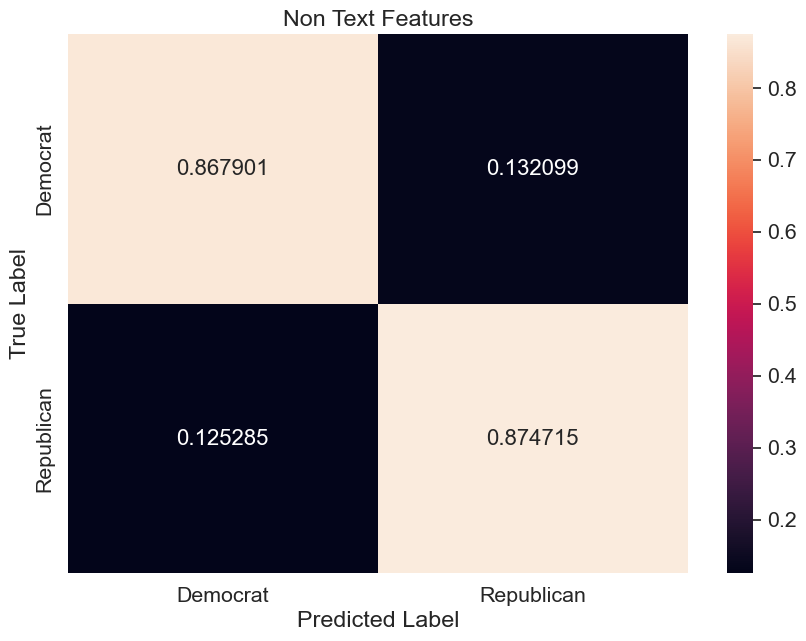

Best hyperparameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
              precision    recall  f1-score   support

    Democrat       0.93      0.86      0.89       810
  Republican       0.78      0.88      0.83       439

    accuracy                           0.87      1249
   macro avg       0.85      0.87      0.86      1249
weighted avg       0.88      0.87      0.87      1249



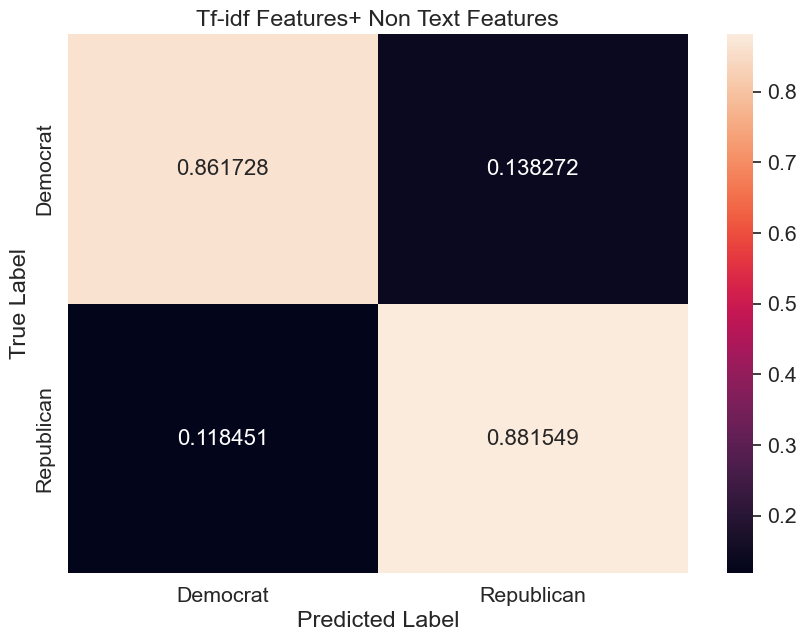

In [70]:
for dataframe, featurization in zip(dataframes, featurization_technique):
    
    dataframe.columns = dataframe.columns.astype(str) 
    
  
    X_train, X_test, y_train, y_test = train_test_split(dataframe,         
                                                        y_party,                
                                                        train_size = .75,  
                                                        test_size=.25, 
                                                        stratify=  y_party, 
                                                        random_state = 10) 
    
   
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],  
        'penalty': ['l1', 'l2'],  
        'solver': ['liblinear']  }
    
    logit_reg = LogisticRegression(class_weight='balanced', max_iter=500)
    grid_search = GridSearchCV(logit_reg,
                                param_grid, 
                                cv=5,
                                scoring='accuracy',
                                n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)


    print("Best hyperparameters:", grid_search.best_params_)
    print(classification_report( y_test, y_pred))

    
   
    cf_matrix = confusion_matrix(y_test,             
                                 y_pred,             
                                 normalize = "true") 

    df_cm = pd.DataFrame(cf_matrix,          
                         range(2), range(2)) 

    
    df_cm = df_cm.rename(index=str, 
                         columns={0: "Democrat", 
                                  1: "Republican"})

   
    df_cm.index = ["Democrat", "Republican"]
    
 
    plt.figure(figsize = (10,7)) 
    sns.set(font_scale=1.4)      
    sns.heatmap(df_cm,           
                annot=True,    
                annot_kws={"size": 16},
                fmt='g')
    

    plt.title(featurization)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

### Predict Partisanship with Non-text Features

In [71]:
best_features4position = non_text_features.reset_index(drop = True).join(tfidf_df, rsuffix='_tfidf')

In [72]:
dataframes = [non_text_features,
              best_features4position]


featurization_technique = ['Non Text Features',
                           'Tf-idf Features+ Non Text Features']

Best hyperparameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
              precision    recall  f1-score   support

         Rep       0.91      0.75      0.82       963
         Sen       0.47      0.74      0.58       286

    accuracy                           0.75      1249
   macro avg       0.69      0.75      0.70      1249
weighted avg       0.81      0.75      0.77      1249



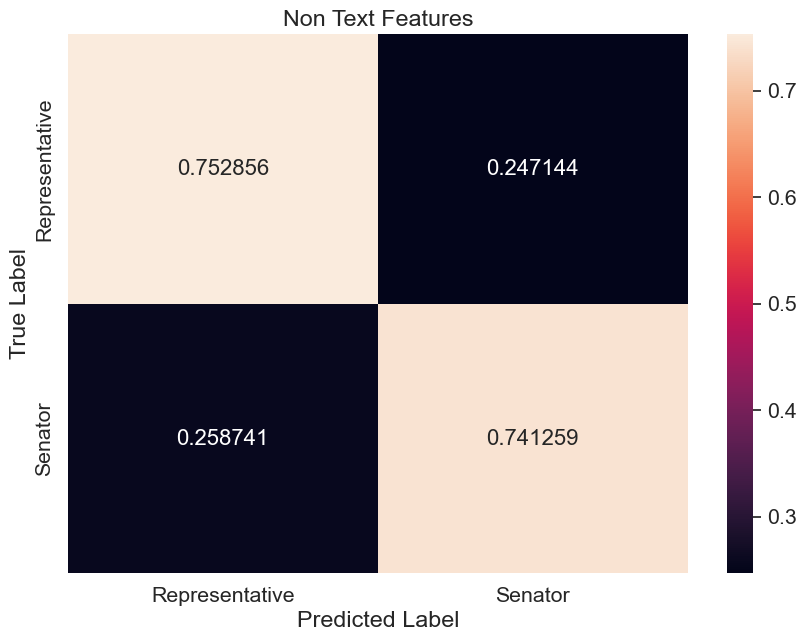

/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best hyperparameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
              precision    recall  f1-score   support

         Rep       0.88      0.87      0.87       963
         Sen       0.57      0.58      0.58       286

    accuracy                           0.80      1249
   macro avg       0.72      0.73      0.72      1249
weighted avg       0.81      0.80      0.80      1249



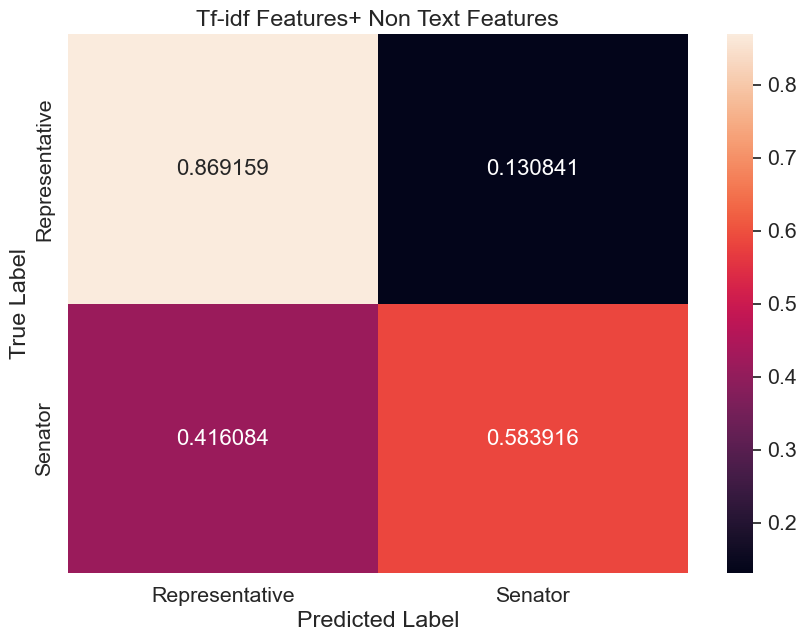

In [73]:
for dataframe, featurization in zip(dataframes, featurization_technique):
    
    dataframe.columns = dataframe.columns.astype(str) 

    X_train, X_test, y_train, y_test = train_test_split(dataframe,         
                                                        y_position,                
                                                        train_size = .75,  
                                                        test_size=.25,
                                                        stratify=y_position, 
                                                        random_state = 10) 
    
    smote = SMOTE()
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    
    
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],  
        'penalty': ['l1', 'l2'],  
        'solver': ['liblinear']  }
    
    logit_reg = LogisticRegression(class_weight='balanced', max_iter=500)
    grid_search = GridSearchCV(logit_reg,
                                param_grid, 
                                cv=5,
                                scoring='accuracy',
                                n_jobs=-1)
    grid_search.fit(X_resampled, y_resampled)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)


    print("Best hyperparameters:", grid_search.best_params_)
    print(classification_report( y_test, y_pred))
    

    cf_matrix = confusion_matrix(y_test,             
                                 y_pred,             
                                 normalize = "true") 

    
    df_cm = pd.DataFrame(cf_matrix,          
                         range(2), range(2)) 

    
    df_cm = df_cm.rename(index=str, 
                         columns={0: "Representative", 
                                  1: "Senator"})

   
    df_cm.index = ["Representative", "Senator"]
    

    plt.figure(figsize = (10,7)) 
    sns.set(font_scale=1.4)      
    sns.heatmap(df_cm,           
                annot=True,    
                annot_kws={"size": 16},
                fmt='g')
    

    plt.title(featurization)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

## Discussion Questions

1. Why do standard preprocessing techniques need to be further customized to a particular corpus?

Standard preprocessing steps need to be adjusted to accommodate the unique characteristics of a particular corpus.
Unlike structured data, text data lacks a uniform format, making it difficult to apply a one-size-fits-all preprocessing approach.

From a **format perspective**, preprocessing must be tailored to the specific content and source of the corpus. For example, social media data collected via web scraping often requires extensive cleaning to remove messy elements.

From a **content perspective**, preprocessing must address challenges such as word omissions and polysemy (multiple meanings of a word): In pretrained word embedding models, key terms from a specific corpus may not be included, leading to missing representations. Different domains use certain words in unique ways, which can significantly alter their position in the vector space. Therefore, fine-tuning must be performed based on the target corpus to ensure accurate representation.

2. Did you find evidence for the idea that Democrats and Republicans have different sentiments in their tweets? What about Senators and Representatives?

**When using TextBlob and VADER for sentiment analysis, signs of polarization appear between Democrats and Republicans as well as between Senators and Representatives.** For example, VADER’s results indicate that Republicans exhibit more negative sentiment than Democrats. Additionally, compared to the smoother sentiment distribution of Senators (orange line), the negative sentiment of Representatives appears more concentrated, reinforcing the idea of polarization. These observations align with the hypothesis that Republicans display stronger sentiment contrasts than Democrats, and that the Senate is more moderate compared to the House.

H**owever, classification results suggest that sentiment scores are not highly effective in predicting party affiliation or congressional position.** Models relying on sentiment analysis performed the worst, whereas TF-IDF and word embeddings were significantly more effective at making accurate predictions. 

Compared to tweet length and sentiment scores, TF-IDF and word embeddings preserve more semantic information—focusing on what is said rather than how it is said. This suggests that rather than being distinguished by overt sentiment expression, the differences between Democrats and Republicans, as well as between Senators and Representatives, lie more in the actual content of their tweets. If so, political communication differences may be more about agenda setting, i.e., primarily discussing different topics, rather than direct emotional polarization.

3. Why is validating your exploratory and unsupervised learning approaches with a supervised learning algorithm valuable?

First, unsupervised methods identify patterns based on the inherent structure of the data, but these patterns are not always meaningful or relevant to the researcher’s objectives. Supervised validation ensures that the discovered patterns actually correspond to distinctions that matter.

Second, supervised validation helps assess the quality of feature engineering. With only unsupervised results, it is difficult to determine whether engineered features perform as expected. Using these features as inputs for supervised models allows researchers to evaluate whether they effectively capture task-relevant information and improve model performance.

Third, when designed effectively, supervised validation can enhance the interpretability of unsupervised results. Since labels in supervised learning are typically human-interpretable and relevant, analyzing how unsupervised learning results affect supervised model performance can provide insights into the relationship between unsupervised features and the target variable. For example, if a classification model based on sentiment scores performs poorly, it may indicate that the differences in sentiment between Democratic and Republican tweets are not as significant as expected.

4. Did text only, non-text only, or text and non-text features together perform the best? What is the intuition behind combining text and non-text features in a supervised learning algorithm?

In this case, text and non-text features together perform the best. Text-only models perform worse than models using non-text features. For party membership classification, adding text features slightly improves performance, but for position classification, incorporating text features improves model performance but actually reduces model performance on recognizing senators.

Integrating both text and non-text features in a supervised learning algorithm leads to more accurate and robust results. While text features may contain valuable information, they can also be sparse and noisy, negatively impacting model performance. Incorporating non-text features can stabilize results while still allowing the rich information in text features to improve classification for cases where non-text features alone are insufficient. Additionally, interactions between text and non-text features may reveal hidden patterns that further enhance classification performance.